In [1]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
plt.ioff()
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
import mantrap
import mantrap_evaluation
import datetime
import numpy as np
import torch
import random

In [3]:
env = mantrap.environment.Trajectron(ego_position=torch.tensor([-4, 1]))
env.add_ado(position=torch.tensor([5, 0]), velocity=torch.tensor([1.0, -0.5]), color=np.array([1, 0, 0]))
env.add_ado(position=torch.tensor([5, -6]), velocity=torch.tensor([-1, 0]), color=np.array([0.5, 0.1, 1.0]))
env.add_ado(position=torch.tensor([-7, -5]), velocity=torch.tensor([0.1, 1.3]), color=np.array([0, 0, 1]))
env.add_ado(position=torch.tensor([2, 2]), velocity=torch.tensor([-1.0, -1.0]), color=np.array([1, 0, 1]))
env.add_ado(position=torch.tensor([-5, 4]), velocity=torch.tensor([0.5, 0.5]), color=np.array([0, 1, 0]))

goal = torch.tensor([3, -1])

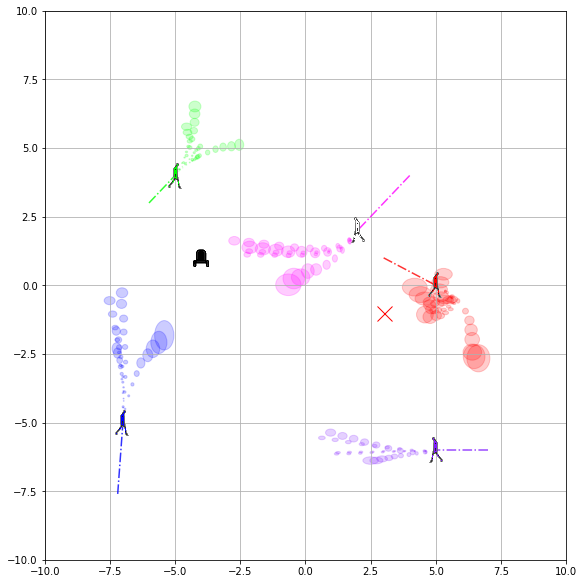

In [4]:
ego_trajectory = torch.ones((10, 5))
ego_trajectory[:, 0:2] = env.ego.position
dist_dict_wo = env.compute_distributions(ego_trajectory, vel_dist=False)
mantrap.visualization.visualize_prediction(env, ego_planned=ego_trajectory, ego_goal=goal, ado_pos_gmm=dist_dict_wo)
plt.show()

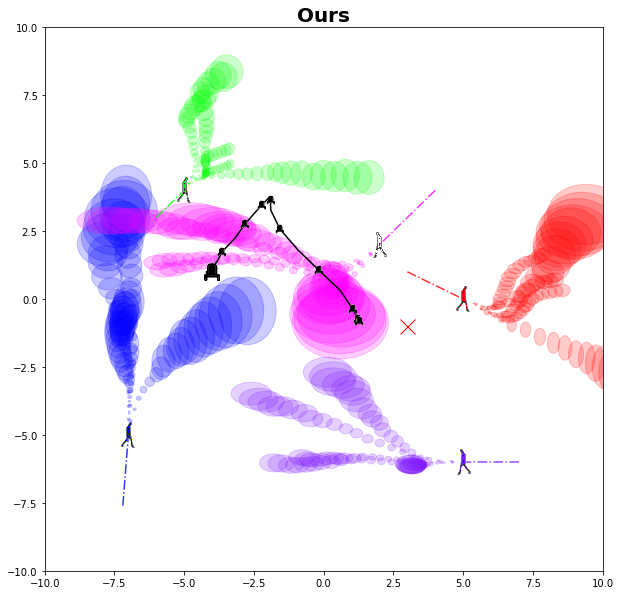

In [6]:
#solvers = [(mantrap.solver.IPOPTSolver, 
#            [mantrap.modules.baselines.InteractionEllipsoidModule, 
#             mantrap.modules.ControlLimitModule, mantrap.modules.GoalNormModule], "Decoupled"),
#           (mantrap.solver.baselines.MonteCarloTreeSearch, None, "MCTS"), 
#           (mantrap.solver.baselines.RRTStarSolver, None, "RRT*"),
#           (mantrap.solver.IPOPTSolver, None, "Ours")]

solvers = [(mantrap.solver.IPOPTSolver, None, "Ours")]

num_solvers = len(solvers)
seed = 15
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

fig, ax = plt.subplots(1, num_solvers, figsize=(10 * num_solvers, 10))
for i, (solver_type, solver_modules, solver_name) in tqdm(enumerate(solvers), total=num_solvers):
    solver = solver_type(env=env, goal=goal, modules=solver_modules, 
                         attention_module=mantrap.attention.ClosestModule,
                         is_logging=True)
    
    ego_trajectory, _,  = solver.solve(time_steps=20, max_cpu_time=20.0)
    ado_dist_dict = env.compute_distributions(ego_trajectory, vel_dist=False)

    mantrap.visualization.visualize_prediction(env, ego_planned=ego_trajectory, ego_goal=goal,
                                               ado_pos_gmm=ado_dist_dict,
                                               title=solver_name, grid=False, ax=ax)    
    

date_string = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
plt.savefig(f"qualitative_{date_string}.png", bbox_inches='tight')
plt.show()